In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2

import keras
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [2]:
def detect_faces(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    return faces

In [3]:
# Função de pré-processamento
def preprocess_image(label, image):
    image = tf.image.resize(image, [224, 224])  # Redimensionar
    image = tf.cast(image, tf.float32) / 255.0  # Normalizar (0 a 1)

    label = table.lookup(label)  # Map string label to integer
    return image, tf.cast(label, tf.int32)

In [4]:
builder = 'lfw'

ds = tfds.load(builder, split='train', as_supervised=True)

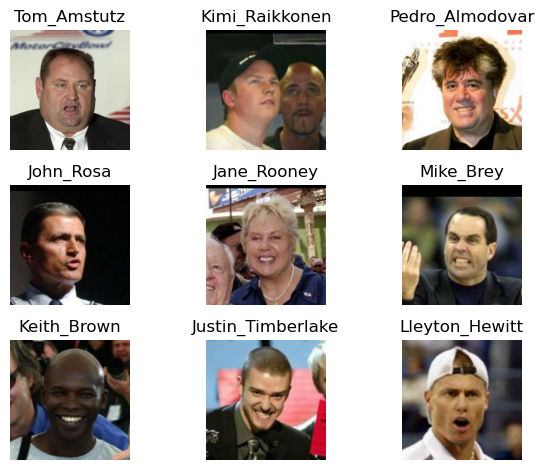

In [5]:
for i, (label, image) in enumerate(ds.take(9)):
  label = label.numpy().decode('utf-8')
  #image = tensor[1].numpy()
  plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
labels = [l.numpy().decode('utf-8') for l, _ in ds]
unique_labels = list(set(labels))
label_to_int = {label: i for i, label in enumerate(unique_labels)}
num_classes = len(unique_labels)

In [7]:
for l,i in ds.take(2):
  print(l.numpy().decode('utf_8'),i.shape)

Tom_Amstutz (250, 250, 3)
Kimi_Raikkonen (250, 250, 3)


In [8]:
# Create a TensorFlow lookup table
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(unique_labels),
        values=tf.constant(list(range(len(unique_labels)))),
    ),
    default_value=-1  # Default value if key is not found
)

In [9]:
ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [11]:
# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar camadas de saída
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Define split proportions
VALIDATION_SPLIT = 0.2  # 20% validation
TRAIN_SPLIT = 1.0 - VALIDATION_SPLIT

# Compute sizes
total_size = tf.data.experimental.cardinality(ds).numpy()
train_size = int(TRAIN_SPLIT * total_size)
val_size = total_size - train_size

# Split into train and validation
train_dataset = ds.take(train_size)
validation_dataset = ds.skip(train_size)
# Batch dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [16]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data=validation_dataset, epochs=10)


Epoch 1/10


331/331 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.0399 - loss: 8.1123 - val_accuracy: 0.0438 - val_loss: 7.7891
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.0538 - loss: 6.3102 - val_accuracy: 0.0506 - val_loss: 7.9380
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.0690 - loss: 5.5085 - val_accuracy: 0.0604 - val_loss: 8.2432
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 663s 2s/step - accuracy: 0.0967 - loss: 4.8699 - val_accuracy: 0.0665 - val_loss: 8.4565
Epoch 5/10
124/331 ━━━━━━━━━━━━━━━━━━━━ 5:23 2s/step - accuracy: 0.1522 - loss: 4.2406

KeyboardInterrupt: 